In [1]:
#pip install torchtext

In [2]:
#pip install -U torchdata

In [3]:
#pip install -U spacy

In [4]:
SRC_LANGUAGE = 'de'
TGT_LANGUAGE = 'en'
token_transform = {}
vocab_transform = {}

In [5]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import multi30k, Multi30k
from typing import Iterable, List

/home/orchid/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
#pip install spacy


In [7]:
#! python -m spacy download en_core_web_sm

In [8]:
#! python -m spacy download de_core_news_sm


In [9]:
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='de_core_news_sm')
token_transform[TGT_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')

In [10]:
print(token_transform[TGT_LANGUAGE]("Narendra modi is a the Prime Minister Of India"))

['Narendra', 'modi', 'is', 'a', 'the', 'Prime', 'Minister', 'Of', 'India']


In [11]:
print(token_transform[SRC_LANGUAGE]("Heute möchte ich Sie bitten - das ist auch der Wunsch einiger Kolleginnen und Kollegen -, allen Opfern der Stürme, insbesondere in den verschiedenen Ländern der Europäischen Union, in einer Schweigeminute zu gedenken."))

['Heute', 'möchte', 'ich', 'Sie', 'bitten', '-', 'das', 'ist', 'auch', 'der', 'Wunsch', 'einiger', 'Kolleginnen', 'und', 'Kollegen', '-', ',', 'allen', 'Opfern', 'der', 'Stürme', ',', 'insbesondere', 'in', 'den', 'verschiedenen', 'Ländern', 'der', 'Europäischen', 'Union', ',', 'in', 'einer', 'Schweigeminute', 'zu', 'gedenken', '.']


In [12]:
from typing import Iterable, List
from torchtext import data

In [13]:
with open("train.de","r") as f:
    train_iter_de = f.readlines()
with open("train.en","r") as f:
    train_iter_en = f.readlines()

In [14]:
def yield_tokens(data_iter: Iterable, language: str) -> List[str]:
    for data_sample in data_iter:
        yield token_transform[language](data_sample)


In [15]:
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

In [16]:
train_iterator_de = iter(train_iter_de)
train_iterator_en = iter(train_iter_en)
vocab_transform[SRC_LANGUAGE] = build_vocab_from_iterator(yield_tokens(train_iterator_de, SRC_LANGUAGE),min_freq=1,specials=special_symbols,special_first=True)
vocab_transform[TGT_LANGUAGE] = build_vocab_from_iterator(yield_tokens(train_iterator_en, TGT_LANGUAGE),min_freq=1,specials=special_symbols,special_first=True)

# Set ``UNK_IDX`` as the default index. This index is returned when the token is not found.
# If not set, it throws ``RuntimeError`` when the queried token is not found in the Vocabulary.
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
  vocab_transform[ln].set_default_index(UNK_IDX)

In [17]:
print(vocab_transform['en']['Commission'])

35


In [18]:
from torch import Tensor
import torch
import torch.nn as nn
from torch.nn import Transformer
import math
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# helper Module that adds positional encoding to the token embedding to introduce a notion of word order.
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

# helper Module to convert tensor of input indices into corresponding tensor of token embeddings
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

# Seq2Seq Network
class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 src_vocab_size: int,
                 tgt_vocab_size: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super(Seq2SeqTransformer, self).__init__()
        self.transformer = Transformer(d_model=emb_size,
                                       nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)

    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)

In [19]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask


def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

In [20]:
torch.manual_seed(0)

SRC_VOCAB_SIZE = len(vocab_transform[SRC_LANGUAGE])
TGT_VOCAB_SIZE = len(vocab_transform[TGT_LANGUAGE])
EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512
BATCH_SIZE = 64
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3

transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

/home/orchid/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [21]:
from torch.nn.utils.rnn import pad_sequence

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids: List[int]):
    return torch.cat((torch.tensor([BOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))

# ``src`` and ``tgt`` language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tensors
def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n")))
        tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n")))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch, tgt_batch

In [22]:
with open("train.de","r") as f:
    src_list_train = f.readlines()
with open("train.en","r") as f:
    tgt_list_train = f.readlines()

print(src_list_train[0])
print(tgt_list_train[0])

Wiederaufnahme der Sitzungsperiode

Resumption of the session



In [23]:
with open("val.de","r") as f:
    src_list_val = f.readlines()
with open("val.en","r") as f:
    tgt_list_val = f.readlines()

print(src_list_val[0])
print(tgt_list_val[0])

Die Premierminister Indiens und Japans trafen sich in Tokio.

India and Japan prime ministers meet in Tokyo



In [24]:
with open("test.de","r") as f:
    src_list_test = f.readlines()
with open("test.en","r") as f:
    tgt_list_test = f.readlines()
 
print(src_list_test[0])
print(tgt_list_test[0])   


Obama empfängt Netanyahu

Obama receives Netanyahu



In [25]:
from torch.utils.data import Dataset

class TranslationDataset(Dataset):
    def __init__(self, src_list, tar_list):
        self.src_list = src_list
        self.tar_list = tar_list

    def __len__(self):
        return len(self.src_list)

    def __getitem__(self, idx):
        src = self.src_list[idx]
        tar = self.tar_list[idx]
        return src, tar


In [26]:
from torch.utils.data import DataLoader

def train_epoch(model, optimizer):
    model.train()
    losses = 0
    train_dataset = TranslationDataset(src_list_train, tgt_list_train)
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)
    for src, tgt in train_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        optimizer.zero_grad()

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss.backward()

        optimizer.step()
        losses += loss.item()

    return losses / len(list(train_dataloader))


def evaluate(model):
    model.eval()
    losses = 0

    val_dataset = TranslationDataset(src_list_val, tgt_list_val)
    val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    for src, tgt in val_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        losses += loss.item()

    return losses / len(list(val_dataloader))

In [27]:
#pip install torch torchtext sacrebleu nltk bert-score

In [28]:
from timeit import default_timer as timer
import torch
from torchtext.data.metrics import bleu_score
import nltk
from bert_score import score

In [29]:
train_loss_plot=[]
val_loss_plot=[]

In [30]:
# src_list_train = src_list_train[:2]
# tgt_list_train = tgt_list_train[:2]
# src_list_val = src_list_val[:2]
# tgt_list_val = tgt_list_val[:2]
# src_list_test = src_list_test[:2]
# tgt_list_test = tgt_list_test[:2]

In [31]:
from tqdm import tqdm
from timeit  import default_timer as timer

NUM_EPOCHS = 100
best_val_loss = float('inf')
patience = 100

for epoch in tqdm(range(1, NUM_EPOCHS + 1), desc="Epochs"):
    start_time = timer()
    train_loss = train_epoch(transformer, optimizer)
    train_loss_plot.append(train_loss)
    end_time = timer()
    val_loss = evaluate(transformer)
    val_loss_plot.append(val_loss)
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))

    # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        print("Best model at epoch:",epoch)
        torch.save(transformer.state_dict(), 'best_model.pth')  # Save the best model checkpoint
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered at:",epoch)
            break


def greedy_decode(model, src, src_mask, max_len, start_symbol):
  src = src.to(DEVICE)
  src_mask = src_mask.to(DEVICE)

  memory = model.encode(src, src_mask)
  ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
  for i in range(max_len-1):
    memory = memory.to(DEVICE)
    tgt_mask = (generate_square_subsequent_mask(ys.size(0))
          .type(torch.bool)).to(DEVICE)
    out = model.decode(ys, memory, tgt_mask)
    out = out.transpose(0, 1)
    prob = model.generator(out[:, -1])
    _, next_word = torch.max(prob, dim=1)
    next_word = next_word.item()

    ys = torch.cat([ys,
            torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
    if next_word == EOS_IDX:
      break
  return ys


def translate(model: torch.nn.Module, src_sentence: str):
  model.eval()
  src = text_transform[SRC_LANGUAGE](src_sentence).view(-1, 1).to(DEVICE)
  num_tokens = src.shape[0]
  src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool).to(DEVICE)
  tgt_tokens = greedy_decode(
    model,  src, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX).flatten()
  return " ".join(vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt_tokens.cpu().numpy()))).replace("<bos>", "").replace("<eos>", "")


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]/home/orchid/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch: 1, Train loss: 5.756, Val loss: 6.651, Epoch time = 87.387s
Best model at epoch: 1


Epochs:   1%|          | 1/100 [01:29<2:28:18, 89.88s/it]

Epoch: 2, Train loss: 4.746, Val loss: 6.311, Epoch time = 88.635s
Best model at epoch: 2


Epochs:   2%|▏         | 2/100 [03:00<2:27:46, 90.47s/it]

Epoch: 3, Train loss: 4.323, Val loss: 6.066, Epoch time = 88.996s
Best model at epoch: 3


Epochs:   3%|▎         | 3/100 [04:31<2:26:48, 90.81s/it]

Epoch: 4, Train loss: 3.985, Val loss: 5.917, Epoch time = 88.950s
Best model at epoch: 4


Epochs:   4%|▍         | 4/100 [06:03<2:25:32, 90.97s/it]

Epoch: 5, Train loss: 3.702, Val loss: 5.900, Epoch time = 88.886s
Best model at epoch: 5


Epochs:   6%|▌         | 6/100 [09:04<2:22:06, 90.71s/it]

Epoch: 6, Train loss: 3.454, Val loss: 5.912, Epoch time = 88.967s
Epoch: 7, Train loss: 3.235, Val loss: 5.884, Epoch time = 89.074s
Best model at epoch: 7


Epochs:   8%|▊         | 8/100 [12:05<2:19:01, 90.67s/it]

Epoch: 8, Train loss: 3.042, Val loss: 5.935, Epoch time = 89.012s


Epochs:   9%|▉         | 9/100 [13:36<2:17:17, 90.52s/it]

Epoch: 9, Train loss: 2.868, Val loss: 5.965, Epoch time = 89.062s


Epochs:  10%|█         | 10/100 [15:06<2:15:36, 90.41s/it]

Epoch: 10, Train loss: 2.713, Val loss: 6.158, Epoch time = 89.012s


Epochs:  11%|█         | 11/100 [16:36<2:13:59, 90.33s/it]

Epoch: 11, Train loss: 2.573, Val loss: 6.116, Epoch time = 89.015s


Epochs:  12%|█▏        | 12/100 [18:06<2:12:23, 90.26s/it]

Epoch: 12, Train loss: 2.446, Val loss: 6.048, Epoch time = 88.970s


Epochs:  13%|█▎        | 13/100 [19:36<2:10:49, 90.23s/it]

Epoch: 13, Train loss: 2.328, Val loss: 6.070, Epoch time = 89.005s


Epochs:  14%|█▍        | 14/100 [21:06<2:09:16, 90.19s/it]

Epoch: 14, Train loss: 2.220, Val loss: 6.119, Epoch time = 88.951s


Epochs:  15%|█▌        | 15/100 [22:36<2:07:45, 90.18s/it]

Epoch: 15, Train loss: 2.119, Val loss: 6.191, Epoch time = 89.042s


Epochs:  16%|█▌        | 16/100 [24:07<2:06:15, 90.18s/it]

Epoch: 16, Train loss: 2.023, Val loss: 6.402, Epoch time = 89.033s


Epochs:  17%|█▋        | 17/100 [25:37<2:04:44, 90.17s/it]

Epoch: 17, Train loss: 1.938, Val loss: 6.446, Epoch time = 89.022s


Epochs:  18%|█▊        | 18/100 [27:07<2:03:15, 90.19s/it]

Epoch: 18, Train loss: 1.851, Val loss: 6.496, Epoch time = 89.072s


Epochs:  19%|█▉        | 19/100 [28:37<2:01:44, 90.18s/it]

Epoch: 19, Train loss: 1.772, Val loss: 6.400, Epoch time = 89.034s


Epochs:  20%|██        | 20/100 [30:07<2:00:14, 90.19s/it]

Epoch: 20, Train loss: 1.696, Val loss: 6.543, Epoch time = 89.052s


Epochs:  21%|██        | 21/100 [31:38<1:58:44, 90.18s/it]

Epoch: 21, Train loss: 1.625, Val loss: 6.594, Epoch time = 89.038s


Epochs:  22%|██▏       | 22/100 [33:08<1:57:14, 90.18s/it]

Epoch: 22, Train loss: 1.556, Val loss: 6.558, Epoch time = 89.042s


Epochs:  23%|██▎       | 23/100 [34:38<1:55:44, 90.19s/it]

Epoch: 23, Train loss: 1.493, Val loss: 6.612, Epoch time = 89.054s


Epochs:  24%|██▍       | 24/100 [36:08<1:54:14, 90.19s/it]

Epoch: 24, Train loss: 1.432, Val loss: 6.586, Epoch time = 89.046s


Epochs:  25%|██▌       | 25/100 [37:38<1:52:43, 90.18s/it]

Epoch: 25, Train loss: 1.374, Val loss: 6.531, Epoch time = 89.034s


Epochs:  26%|██▌       | 26/100 [39:08<1:51:13, 90.18s/it]

Epoch: 26, Train loss: 1.315, Val loss: 6.591, Epoch time = 89.035s


Epochs:  27%|██▋       | 27/100 [40:39<1:49:43, 90.19s/it]

Epoch: 27, Train loss: 1.262, Val loss: 6.603, Epoch time = 89.077s


Epochs:  28%|██▊       | 28/100 [42:09<1:48:15, 90.22s/it]

Epoch: 28, Train loss: 1.209, Val loss: 6.722, Epoch time = 89.141s


Epochs:  29%|██▉       | 29/100 [43:39<1:46:45, 90.22s/it]

Epoch: 29, Train loss: 1.158, Val loss: 6.900, Epoch time = 89.076s


Epochs:  30%|███       | 30/100 [45:09<1:45:16, 90.23s/it]

Epoch: 30, Train loss: 1.107, Val loss: 6.898, Epoch time = 89.124s


Epochs:  31%|███       | 31/100 [46:40<1:43:45, 90.22s/it]

Epoch: 31, Train loss: 1.061, Val loss: 6.920, Epoch time = 89.070s


Epochs:  32%|███▏      | 32/100 [48:10<1:42:14, 90.21s/it]

Epoch: 32, Train loss: 1.015, Val loss: 7.073, Epoch time = 89.051s


Epochs:  33%|███▎      | 33/100 [49:40<1:40:44, 90.22s/it]

Epoch: 33, Train loss: 0.973, Val loss: 7.117, Epoch time = 89.087s


Epochs:  34%|███▍      | 34/100 [51:10<1:39:13, 90.21s/it]

Epoch: 34, Train loss: 0.931, Val loss: 7.087, Epoch time = 89.046s


Epochs:  35%|███▌      | 35/100 [52:40<1:37:44, 90.22s/it]

Epoch: 35, Train loss: 0.893, Val loss: 7.249, Epoch time = 89.105s


Epochs:  36%|███▌      | 36/100 [54:11<1:36:13, 90.21s/it]

Epoch: 36, Train loss: 0.854, Val loss: 7.308, Epoch time = 89.056s


Epochs:  37%|███▋      | 37/100 [55:41<1:34:43, 90.21s/it]

Epoch: 37, Train loss: 0.819, Val loss: 7.543, Epoch time = 89.063s


Epochs:  38%|███▊      | 38/100 [57:11<1:33:14, 90.23s/it]

Epoch: 38, Train loss: 0.785, Val loss: 7.592, Epoch time = 89.129s


Epochs:  39%|███▉      | 39/100 [58:41<1:31:41, 90.19s/it]

Epoch: 39, Train loss: 0.754, Val loss: 7.497, Epoch time = 88.973s


Epochs:  40%|████      | 40/100 [1:00:11<1:30:08, 90.13s/it]

Epoch: 40, Train loss: 0.723, Val loss: 7.669, Epoch time = 88.871s


Epochs:  41%|████      | 41/100 [1:01:41<1:28:34, 90.07s/it]

Epoch: 41, Train loss: 0.696, Val loss: 7.572, Epoch time = 88.792s


Epochs:  42%|████▏     | 42/100 [1:03:11<1:27:04, 90.08s/it]

Epoch: 42, Train loss: 0.669, Val loss: 7.839, Epoch time = 88.977s


Epochs:  43%|████▎     | 43/100 [1:04:42<1:25:37, 90.14s/it]

Epoch: 43, Train loss: 0.644, Val loss: 7.526, Epoch time = 89.116s


Epochs:  44%|████▍     | 44/100 [1:06:12<1:24:09, 90.17s/it]

Epoch: 44, Train loss: 0.618, Val loss: 7.516, Epoch time = 89.124s


Epochs:  45%|████▌     | 45/100 [1:07:42<1:22:41, 90.20s/it]

Epoch: 45, Train loss: 0.595, Val loss: 7.550, Epoch time = 89.131s


Epochs:  46%|████▌     | 46/100 [1:09:12<1:21:10, 90.20s/it]

Epoch: 46, Train loss: 0.572, Val loss: 7.549, Epoch time = 89.043s


Epochs:  47%|████▋     | 47/100 [1:10:42<1:19:41, 90.21s/it]

Epoch: 47, Train loss: 0.550, Val loss: 7.701, Epoch time = 89.099s


Epochs:  48%|████▊     | 48/100 [1:12:13<1:18:11, 90.23s/it]

Epoch: 48, Train loss: 0.529, Val loss: 7.710, Epoch time = 89.134s


Epochs:  49%|████▉     | 49/100 [1:13:43<1:16:41, 90.23s/it]

Epoch: 49, Train loss: 0.508, Val loss: 7.785, Epoch time = 89.084s


Epochs:  50%|█████     | 50/100 [1:15:13<1:15:11, 90.22s/it]

Epoch: 50, Train loss: 0.490, Val loss: 7.945, Epoch time = 89.071s


Epochs:  51%|█████     | 51/100 [1:16:43<1:13:41, 90.23s/it]

Epoch: 51, Train loss: 0.473, Val loss: 7.968, Epoch time = 89.116s


Epochs:  52%|█████▏    | 52/100 [1:18:14<1:12:10, 90.22s/it]

Epoch: 52, Train loss: 0.458, Val loss: 8.025, Epoch time = 89.064s


Epochs:  53%|█████▎    | 53/100 [1:19:44<1:10:40, 90.22s/it]

Epoch: 53, Train loss: 0.443, Val loss: 8.113, Epoch time = 89.077s


Epochs:  54%|█████▍    | 54/100 [1:21:14<1:09:09, 90.21s/it]

Epoch: 54, Train loss: 0.427, Val loss: 8.026, Epoch time = 89.049s


Epochs:  55%|█████▌    | 55/100 [1:22:44<1:07:40, 90.23s/it]

Epoch: 55, Train loss: 0.412, Val loss: 8.089, Epoch time = 89.130s


Epochs:  56%|█████▌    | 56/100 [1:24:15<1:06:10, 90.23s/it]

Epoch: 56, Train loss: 0.397, Val loss: 8.082, Epoch time = 89.092s


Epochs:  57%|█████▋    | 57/100 [1:25:45<1:04:39, 90.22s/it]

Epoch: 57, Train loss: 0.384, Val loss: 8.289, Epoch time = 89.066s


Epochs:  58%|█████▊    | 58/100 [1:27:15<1:03:09, 90.22s/it]

Epoch: 58, Train loss: 0.372, Val loss: 8.305, Epoch time = 89.059s


Epochs:  59%|█████▉    | 59/100 [1:28:45<1:01:38, 90.21s/it]

Epoch: 59, Train loss: 0.359, Val loss: 8.233, Epoch time = 89.055s


Epochs:  60%|██████    | 60/100 [1:30:15<1:00:08, 90.22s/it]

Epoch: 60, Train loss: 0.348, Val loss: 8.138, Epoch time = 89.099s


Epochs:  61%|██████    | 61/100 [1:31:46<58:38, 90.22s/it]  

Epoch: 61, Train loss: 0.337, Val loss: 8.420, Epoch time = 89.076s


Epochs:  62%|██████▏   | 62/100 [1:33:16<57:08, 90.22s/it]

Epoch: 62, Train loss: 0.326, Val loss: 8.375, Epoch time = 89.099s


Epochs:  63%|██████▎   | 63/100 [1:34:46<55:37, 90.21s/it]

Epoch: 63, Train loss: 0.316, Val loss: 8.131, Epoch time = 89.056s


Epochs:  64%|██████▍   | 64/100 [1:36:16<54:07, 90.21s/it]

Epoch: 64, Train loss: 0.308, Val loss: 8.254, Epoch time = 89.065s


Epochs:  65%|██████▌   | 65/100 [1:37:47<52:37, 90.22s/it]

Epoch: 65, Train loss: 0.298, Val loss: 8.172, Epoch time = 89.106s


Epochs:  66%|██████▌   | 66/100 [1:39:17<51:07, 90.21s/it]

Epoch: 66, Train loss: 0.288, Val loss: 8.314, Epoch time = 89.042s


Epochs:  67%|██████▋   | 67/100 [1:40:47<49:37, 90.23s/it]

Epoch: 67, Train loss: 0.282, Val loss: 8.383, Epoch time = 89.124s


Epochs:  68%|██████▊   | 68/100 [1:42:17<48:08, 90.26s/it]

Epoch: 68, Train loss: 0.272, Val loss: 8.349, Epoch time = 89.184s


Epochs:  69%|██████▉   | 69/100 [1:43:48<46:38, 90.27s/it]

Epoch: 69, Train loss: 0.265, Val loss: 8.415, Epoch time = 89.164s


Epochs:  70%|███████   | 70/100 [1:45:18<45:08, 90.27s/it]

Epoch: 70, Train loss: 0.258, Val loss: 8.372, Epoch time = 89.140s


Epochs:  71%|███████   | 71/100 [1:46:48<43:37, 90.27s/it]

Epoch: 71, Train loss: 0.251, Val loss: 8.292, Epoch time = 89.118s


Epochs:  72%|███████▏  | 72/100 [1:48:18<42:07, 90.26s/it]

Epoch: 72, Train loss: 0.244, Val loss: 8.497, Epoch time = 89.095s


Epochs:  73%|███████▎  | 73/100 [1:49:48<40:34, 90.17s/it]

Epoch: 73, Train loss: 0.237, Val loss: 8.442, Epoch time = 88.828s


Epochs:  74%|███████▍  | 74/100 [1:51:18<39:02, 90.08s/it]

Epoch: 74, Train loss: 0.231, Val loss: 8.515, Epoch time = 88.756s


Epochs:  75%|███████▌  | 75/100 [1:52:48<37:32, 90.10s/it]

Epoch: 75, Train loss: 0.226, Val loss: 8.505, Epoch time = 89.000s


Epochs:  76%|███████▌  | 76/100 [1:54:19<36:03, 90.15s/it]

Epoch: 76, Train loss: 0.220, Val loss: 8.486, Epoch time = 89.113s


Epochs:  77%|███████▋  | 77/100 [1:55:49<34:34, 90.20s/it]

Epoch: 77, Train loss: 0.215, Val loss: 8.496, Epoch time = 89.195s


Epochs:  78%|███████▊  | 78/100 [1:57:19<33:05, 90.23s/it]

Epoch: 78, Train loss: 0.210, Val loss: 8.497, Epoch time = 89.146s


Epochs:  79%|███████▉  | 79/100 [1:58:49<31:34, 90.23s/it]

Epoch: 79, Train loss: 0.205, Val loss: 8.531, Epoch time = 89.088s


Epochs:  80%|████████  | 80/100 [2:00:20<30:04, 90.24s/it]

Epoch: 80, Train loss: 0.201, Val loss: 8.517, Epoch time = 89.126s


Epochs:  81%|████████  | 81/100 [2:01:50<28:35, 90.26s/it]

Epoch: 81, Train loss: 0.195, Val loss: 8.434, Epoch time = 89.181s


Epochs:  82%|████████▏ | 82/100 [2:03:20<27:05, 90.28s/it]

Epoch: 82, Train loss: 0.192, Val loss: 8.535, Epoch time = 89.189s


Epochs:  83%|████████▎ | 83/100 [2:04:51<25:34, 90.28s/it]

Epoch: 83, Train loss: 0.187, Val loss: 8.579, Epoch time = 89.140s


Epochs:  84%|████████▍ | 84/100 [2:06:21<24:04, 90.28s/it]

Epoch: 84, Train loss: 0.183, Val loss: 8.661, Epoch time = 89.136s


Epochs:  85%|████████▌ | 85/100 [2:07:51<22:34, 90.30s/it]

Epoch: 85, Train loss: 0.180, Val loss: 8.560, Epoch time = 89.206s


Epochs:  86%|████████▌ | 86/100 [2:09:22<21:04, 90.31s/it]

Epoch: 86, Train loss: 0.176, Val loss: 8.567, Epoch time = 89.182s


Epochs:  87%|████████▋ | 87/100 [2:10:52<19:33, 90.30s/it]

Epoch: 87, Train loss: 0.173, Val loss: 8.712, Epoch time = 89.129s


Epochs:  88%|████████▊ | 88/100 [2:12:22<18:03, 90.29s/it]

Epoch: 88, Train loss: 0.168, Val loss: 8.610, Epoch time = 89.151s


Epochs:  89%|████████▉ | 89/100 [2:13:52<16:33, 90.29s/it]

Epoch: 89, Train loss: 0.165, Val loss: 8.662, Epoch time = 89.130s


Epochs:  90%|█████████ | 90/100 [2:15:23<15:02, 90.27s/it]

Epoch: 90, Train loss: 0.163, Val loss: 8.657, Epoch time = 89.079s


Epochs:  91%|█████████ | 91/100 [2:16:53<13:32, 90.27s/it]

Epoch: 91, Train loss: 0.159, Val loss: 8.629, Epoch time = 89.126s


Epochs:  92%|█████████▏| 92/100 [2:18:23<12:02, 90.28s/it]

Epoch: 92, Train loss: 0.156, Val loss: 8.713, Epoch time = 89.166s


Epochs:  93%|█████████▎| 93/100 [2:19:53<10:31, 90.26s/it]

Epoch: 93, Train loss: 0.153, Val loss: 8.796, Epoch time = 89.089s


Epochs:  94%|█████████▍| 94/100 [2:21:24<09:01, 90.27s/it]

Epoch: 94, Train loss: 0.150, Val loss: 8.692, Epoch time = 89.125s


Epochs:  95%|█████████▌| 95/100 [2:22:54<07:31, 90.27s/it]

Epoch: 95, Train loss: 0.147, Val loss: 8.814, Epoch time = 89.152s


Epochs:  96%|█████████▌| 96/100 [2:24:24<06:01, 90.26s/it]

Epoch: 96, Train loss: 0.144, Val loss: 8.770, Epoch time = 89.105s


Epochs:  97%|█████████▋| 97/100 [2:25:54<04:30, 90.24s/it]

Epoch: 97, Train loss: 0.142, Val loss: 8.742, Epoch time = 89.030s


Epochs:  98%|█████████▊| 98/100 [2:27:25<03:00, 90.25s/it]

Epoch: 98, Train loss: 0.140, Val loss: 8.801, Epoch time = 89.138s


Epochs:  99%|█████████▉| 99/100 [2:28:55<01:30, 90.26s/it]

Epoch: 99, Train loss: 0.137, Val loss: 8.749, Epoch time = 89.141s


Epochs: 100%|██████████| 100/100 [2:30:25<00:00, 90.26s/it]

Epoch: 100, Train loss: 0.134, Val loss: 8.686, Epoch time = 89.076s


In [32]:
#torch.save(transformer.state_dict(), 'transformer_model.pth')

In [33]:
model=Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)
model_state_dict = torch.load('best_model.pth')

# Load the model state into your model instance
model.load_state_dict(model_state_dict)
model = model.to(DEVICE)

/home/orchid/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [34]:
val_translation = []
for i in tqdm(src_list_val):
  val_translation.append(translate(model, i))


100%|██████████| 2169/2169 [02:15<00:00, 16.04it/s]


In [35]:
print(val_translation)

[' The Minister of Ministers and the Portuguese Presidency is in favour of a lot of time .', ' The new Minister of Ministers , in its first time , the first time , has been in its first reading , in its first reading , since its first reading , has been in its first reading and', ' Mr President , in a way of the beginning of the Mediterranean , the economic relations with the world - making process of the world - making process is being used', ' We are going to be able to take more cooperation on the agenda of a whole - scale area .', ' The reports that they are also able to be able to establish a Treaty between two Nations two institutions . ', ' The police industry has been able to be able to be able to take a', ' A result of the car industry , while at a time - fibre derailment - fibre sheepmeat - fibre goatmeat , a number of times - and a reduction in the police - scale disaster was in place in order to', ' This is a case of course , in the case of this kind , a kind of time , a ki

In [36]:
# train_translation=[]
# for i in src_list_train:
#     train_translation.append(translate(model,i))

In [37]:
# print(train_translation)

In [38]:
import matplotlib.pyplot as plt

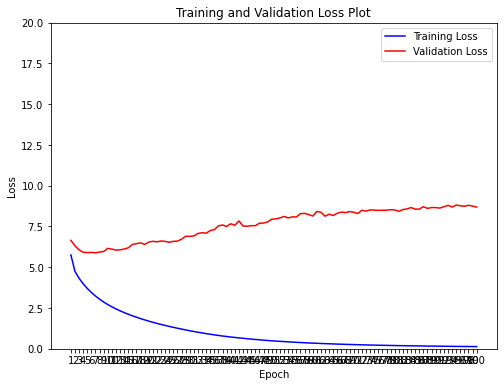

In [39]:
x_values_train = list(range(1, len(train_loss_plot) + 1))

plt.figure(figsize=(8, 6))
plt.plot(x_values_train, train_loss_plot, color='blue', label='Training Loss')
plt.plot(x_values_train, val_loss_plot, color='red', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Plot')
#plt.grid(True)
plt.xticks(x_values_train)
plt.ylim(0,20)
plt.legend()
plt.show()